# X-ray Property - Velocity Dispersion Relation

In this notebook we make a simple comparison of X-ray luminosities/temperatures and optical velocity dispersions to literature. The luminosities/temperatures have been measured during the course of this work, and the velocity dispersions (for all but the group in the foregound of PHL1811), were measured by Stocke et al.

Our data are such that it is not particularly helpful to fit our own scaling relation, but we can overplot them on top of previously measured X-ray property to velocity dispersion scaling relations, such as those measured by Giles et al. from XXL data, and Wilson et al. from XCS data.

## Import Statements

In [2]:
import numpy as np
from astropy.units import Quantity
import pandas as pd
import pickle
from matplotlib import pyplot as plt

from xga.products.relation import ScalingRelation
from xga.models.misc import power_law
from xga.utils import DEFAULT_COSMO

%matplotlib inline

## Loading data tables

Here we load the two data tables required to make the comparison to literature scaling relations. First of all, the optical properties for our groups adopted by Stocke et al. 2019, this includes the velocity dispersion measurement (in fact we exclude most other columns for clarity):

In [3]:
opt_groups = pd.read_csv("../../sample_files/opt_group_info.csv")
opt_groups = opt_groups[['name', 'ov_obs_ad', 'ov_obs_ad_err']]
opt_groups

,name,ov_obs_ad,ov_obs_ad_err
0,25124,448.0,0.0
1,44739,336.0,0.0
2,19670,404.0,0.0
3,12833,444.0,0.0
4,44858,569.0,0.0
5,J215504.8-093520,630.0,110.0
6,J215437.2-091532.4,NaN,NaN
7,50433,338.0,0.0


Secondly, we load our measurements of X-ray properties. We choose the 'standard mode' pipeline run (luminosities are broadly consistent with other modes for this sample), with measurements made within $R_{500}$ (as were those of the scaling relations we compare to):

In [4]:
xray_prop = pd.read_csv("../../outputs/results/ltr_r500_pipeline_results.csv")
xray_prop['opt_name'] = xray_prop['name'].apply(lambda x: x[:5] if len(x) <= 7 else x)
xray_prop

,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,...,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,opt_name
0,25124A,243.629055,26.730240,0.186,867.647767,39.128436,3.817000,0.287230,0.326195,7.396831e+43,...,4.240060,0.463875,0.698658,4.661778e+43,1.474055e+42,1.136021e+42,1.407295e+44,1.243112e+43,8.999482e+42,25124
1,25124B,243.504000,26.691000,0.186,665.433860,93.790303,2.121080,0.453657,1.097385,4.858143e+42,...,1.668870,0.571085,1.111938,3.756145e+42,5.779736e+41,7.552022e+41,7.921396e+42,1.571571e+42,1.660467e+42,25124
2,25124C,243.541000,26.648000,0.186,504.349762,26.563232,1.505450,0.118645,0.157002,4.980125e+42,...,1.475180,0.123717,0.146730,4.692879e+42,3.996000e+41,5.333483e+41,9.510069e+42,9.116242e+41,1.309781e+42,25124
3,44739,229.793620,28.331750,0.118,426.978169,22.844914,1.024810,0.066587,0.081072,2.328422e+42,...,0.993314,0.088181,0.086573,1.873450e+42,2.306554e+41,2.767644e+41,3.233224e+42,3.960150e+41,4.341351e+41,44739
4,19670AB,150.226402,50.800565,0.134,527.139938,30.952352,1.978950,0.341111,0.660766,3.495482e+42,...,1.561920,0.179030,0.293561,2.992024e+42,3.335254e+41,3.754196e+41,6.209580e+42,1.028791e+42,1.035156e+42,19670
5,19670A,150.256710,50.793942,0.134,462.177328,27.670531,1.252010,0.113311,0.139826,1.581114e+42,...,1.333620,0.148756,0.199910,1.176707e+42,3.641293e+41,3.858331e+41,2.310265e+42,7.379632e+41,6.230597e+41,19670
6,19670B,150.214920,50.805014,0.134,591.610814,44.926843,1.907300,0.243713,0.425694,4.533795e+42,...,1.652700,0.244968,0.313360,3.512372e+42,3.266195e+41,5.632695e+41,7.421187e+42,8.747499e+41,8.987884e+41,19670
7,19670C,150.065000,50.746000,0.134,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19670
8,19670D,150.168000,50.686000,0.134,359.762893,58.758058,0.326002,0.070427,0.247115,7.776962e+41,...,0.246174,0.060497,0.107147,6.906259e+41,4.756693e+41,1.577939e+41,1.729986e+42,1.048810e+42,5.710794e+41,19670
9,12833A,129.496800,44.248700,0.145,484.161429,22.267250,1.394590,0.098024,0.113226,3.419655e+42,...,1.416080,0.145301,0.239000,2.240773e+42,3.645432e+41,2.770394e+41,4.498901e+42,7.032202e+41,5.884023e+41,12833


Finally, we merge the two tables so that we have the velocity dispersion and X-ray luminosity values in one place:

In [5]:
comb = pd.merge(opt_groups, xray_prop, left_on='name', right_on='opt_name')
del comb['opt_name']
del comb['name_x']
comb = comb.rename(columns={'name_y': 'name'})
comb

,ov_obs_ad,ov_obs_ad_err,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,...,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,448.0,0.0,25124A,243.629055,26.730240,0.186,867.647767,39.128436,3.817000,0.287230,...,7.694207e+42,4.240060,0.463875,0.698658,4.661778e+43,1.474055e+42,1.136021e+42,1.407295e+44,1.243112e+43,8.999482e+42
1,448.0,0.0,25124B,243.504000,26.691000,0.186,665.433860,93.790303,2.121080,0.453657,...,1.947342e+42,1.668870,0.571085,1.111938,3.756145e+42,5.779736e+41,7.552022e+41,7.921396e+42,1.571571e+42,1.660467e+42
2,448.0,0.0,25124C,243.541000,26.648000,0.186,504.349762,26.563232,1.505450,0.118645,...,1.368388e+42,1.475180,0.123717,0.146730,4.692879e+42,3.996000e+41,5.333483e+41,9.510069e+42,9.116242e+41,1.309781e+42
3,336.0,0.0,44739,229.793620,28.331750,0.118,426.978169,22.844914,1.024810,0.066587,...,5.811503e+41,0.993314,0.088181,0.086573,1.873450e+42,2.306554e+41,2.767644e+41,3.233224e+42,3.960150e+41,4.341351e+41
4,404.0,0.0,19670AB,150.226402,50.800565,0.134,527.139938,30.952352,1.978950,0.341111,...,1.398974e+42,1.561920,0.179030,0.293561,2.992024e+42,3.335254e+41,3.754196e+41,6.209580e+42,1.028791e+42,1.035156e+42
5,404.0,0.0,19670A,150.256710,50.793942,0.134,462.177328,27.670531,1.252010,0.113311,...,7.445787e+41,1.333620,0.148756,0.199910,1.176707e+42,3.641293e+41,3.858331e+41,2.310265e+42,7.379632e+41,6.230597e+41
6,404.0,0.0,19670B,150.214920,50.805014,0.134,591.610814,44.926843,1.907300,0.243713,...,1.244323e+42,1.652700,0.244968,0.313360,3.512372e+42,3.266195e+41,5.632695e+41,7.421187e+42,8.747499e+41,8.987884e+41
7,404.0,0.0,19670C,150.065000,50.746000,0.134,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,404.0,0.0,19670D,150.168000,50.686000,0.134,359.762893,58.758058,0.326002,0.070427,...,3.734298e+41,0.246174,0.060497,0.107147,6.906259e+41,4.756693e+41,1.577939e+41,1.729986e+42,1.048810e+42,5.710794e+41
9,444.0,0.0,12833A,129.496800,44.248700,0.145,484.161429,22.267250,1.394590,0.098024,...,7.096560e+41,1.416080,0.145301,0.239000,2.240773e+42,3.645432e+41,2.770394e+41,4.498901e+42,7.032202e+41,5.884023e+41


## Comparing to scaling relations

Here we compare our measurements to existing scaling relations between X-ray luminosity and velocity dispersion. The selected scaling relations were made from low-mass systems (i.e. galaxy groups).

### Reading out data points

We need to get the data points ready for over-plotting on the scaling relations. This involves reading them out of the combined data table and putting them in astropy quantities - we currently have to manually add zero-value uncertainties for the velocity dispersions, because the adopted values table of Stocke et al. 2019 doesn't include them. We also make sure to multiply the luminosity with the inverse E(z) factor calculated from the cluster redshifts (though we note that XXL used a different cosmological model than we did):

In [6]:
vel_disp = Quantity(comb[['ov_obs_ad', 'ov_obs_ad_err']].values, 'km/s')

inv_e = DEFAULT_COSMO.inv_efunc(comb['redshift'].values)
lx = Quantity(comb[['Lx500_0.5-2.0', 'Lx500_0.5-2.0-', 'Lx500_0.5-2.0+']].values, 
              'erg/s')*inv_e[..., None]
# As we are going to compare the temperatures to a scaling relation that we refit ourselves, and we did not include any E(z) factor
#  in that refit, we don't need to multiply temperature by anything
tx = Quantity(comb[['Tx500', 'Tx500-', 'Tx500+']].values, 'keV')

### Bias corrected relation from XXL selected galaxy groups in GAMA

The relations were measured by [Giles et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.511.1227G/abstract), and we can define XGA scaling relations very easily from the published slopes and normalisations in Table 3 of that work. The first relation is from XXL selected galaxy groups, with corresponding velocity dispersions measured from GAMA, corrected for the XXL selection function:

In [7]:
xxl_lsig = ScalingRelation(np.array([3.95, 0.37]), np.array([0.57, 0.12]), power_law, Quantity(400, 'km/s'), 
                           Quantity(5e+42, 'erg/s'), r'$\sigma_{v}$', r'$E(z)^{-1}L^{\rm{0.5-2.0}}_{\rm{X,500}}$', 
                           dim_hubb_ind=-1, x_data=vel_disp[:, 0], x_err=vel_disp[:, 1].T, 
                           y_data=lx[:, 0], y_err=lx[:, 1].T, point_names=comb['name'].values)
xxl_lsig.model_colour = 'tab:cyan'
xxl_lsig.author = 'Giles et al.'
xxl_lsig.year = 2022
xxl_lsig.name = r"Bias-corrected XXL $L_{\rm{X}}$-$\sigma_{v}$"

### GAMA selected galaxy groups in XXL

The second relation is from the same work (both are displayed in Figure 7 of that paper), and is measured from a sample selected from GAMA, with corresponding X-ray luminosities measured from XXL:

In [8]:
gama_lsig = ScalingRelation(np.array([3.53, 0.7]), np.array([0.59, 0.16]), power_law, Quantity(400, 'km/s'), 
                            Quantity(5e+42, 'erg/s'), r'$\sigma_{v}$', r'$E(z)^{-1}L^{\rm{0.5-2.0}}_{\rm{X,500}}$', 
                            dim_hubb_ind=-1, x_data=vel_disp[:, 0], x_err=vel_disp[:, 1].T, 
                            y_data=lx[:, 0], y_err=lx[:, 1].T, point_names=comb['name'].values)
gama_lsig.model_colour = 'seagreen'
gama_lsig.author = 'Giles et al.'
gama_lsig.year = 2022
gama_lsig.name = r"GAMA $L_{\rm{X}}$-$\sigma_{v}$"

### XCS selected galaxy groups and clusters

We have refit the temperature and velocity dispersion dataset measured and analysed by [Wilson et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463..413W/abstract) - we will overlay our values for comparison purposes. The refit of the relation did not include any E(z) factor, as we aren't making any conclusions from the relation, just doing a direct comparison.

In [9]:
with open('wilson_xcs_txVSveldisp.xgarel', 'rb') as scalo:
    xcs_tx_veldisp = pickle.load(scalo)

xcs_tx_veldisp.model_colour = 'rebeccapurple'
xcs_tx_veldisp.author = 'Wilson et al.'
xcs_tx_veldisp.year = 2016
xcs_tx_veldisp.name = r"XCS $T_{\rm{X}}$-$\sigma_{v}$"

## Plotting our data: $L_{\rm{X}}$-$\sigma_{v}$

Here we make use of the scaling relation objects that we just defined to illustrate how our data compare to the literature relations.

### Labelling our data points for context

First of all, we plot the two scaling relations separately, with our data points. We also turn on labelling of points, and print the group names so it is easy to tell which point belongs to which system:

In [10]:
xxl_lsig.point_names

array(['25124A', '25124B', '25124C', '44739', '19670AB', '19670A',
       '19670B', '19670C', '19670D', '12833A', '12833B', '44858',
       'J215504.8-093520', 'J215437.2-091532.4', '50433'], dtype=object)

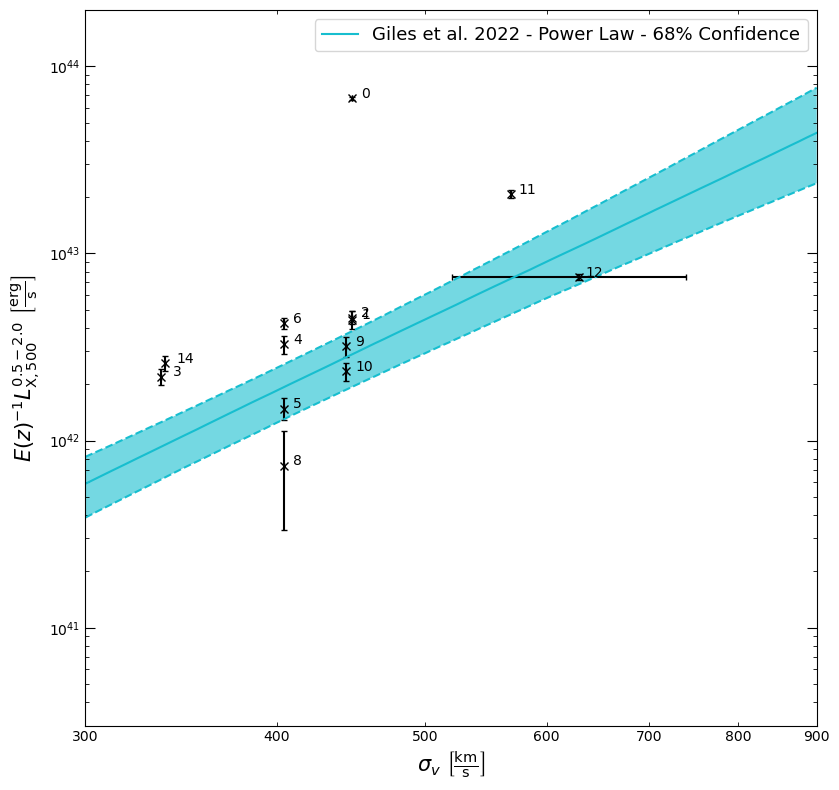

In [11]:
xxl_lsig.view(x_lims=Quantity([300, 900], 'km/s'), y_lims=Quantity([3e+40, 2e+44], 'erg/s'), log_scale=True, label_points=True, 
              conf_level=68, plot_title='', figsize=(8.5, 8), save_path="../../outputs/figures/xxl_veldisp_lx_comp_wlabels.pdf", 
              point_label_offset=(0.01, 0.0001))

In [12]:
gama_lsig.point_names

array(['25124A', '25124B', '25124C', '44739', '19670AB', '19670A',
       '19670B', '19670C', '19670D', '12833A', '12833B', '44858',
       'J215504.8-093520', 'J215437.2-091532.4', '50433'], dtype=object)

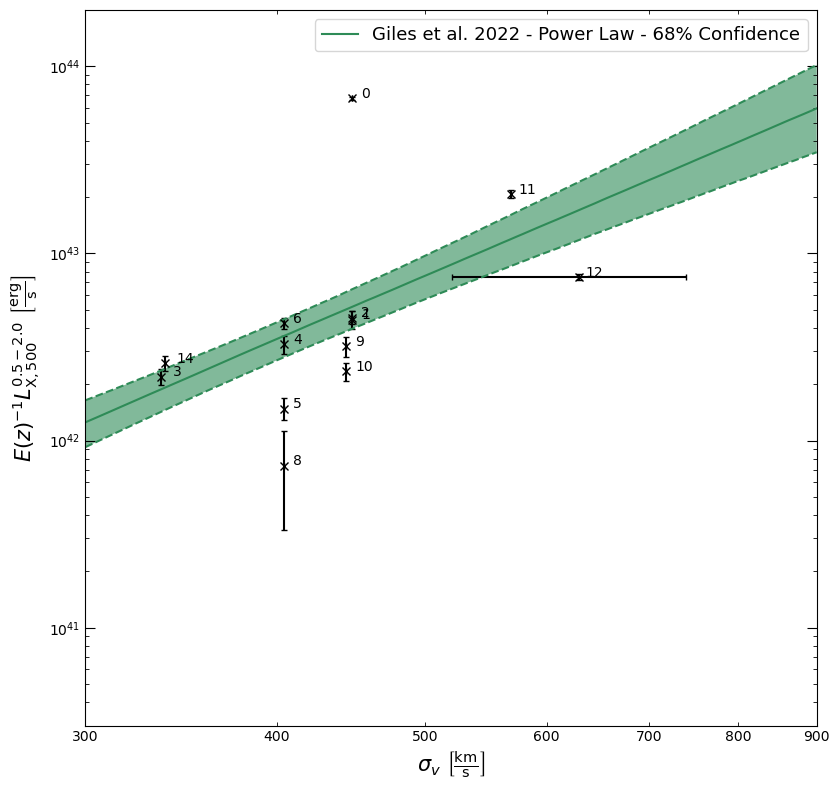

In [13]:
gama_lsig.view(x_lims=Quantity([300, 900], 'km/s'), y_lims=Quantity([3e+40, 2e+44], 'erg/s'), log_scale=True, 
               label_points=True, conf_level=68, plot_title='', figsize=(8.5, 8), 
               save_path="../../outputs/figures/gama_veldisp_lx_comp_wlabels.pdf",
               point_label_offset=(0.01, 0.0001))

### Comparing data to both relations

This not only plots both scaling relations on the same axis, but also overlays our data points as black diamonds. The plot is displayed in the notebook and also saved to disk - we modify the plot from default to connect data points which are different X-ray counterparts of the same group:

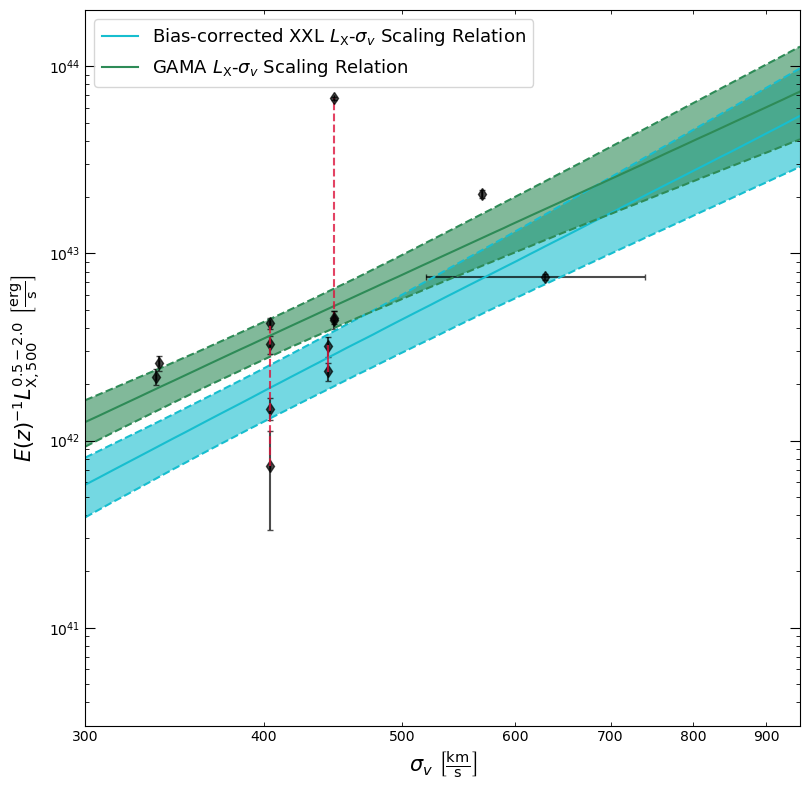

In [69]:
# We redefine the author to trick the automatic visualisation maker into making better labels - this will
#  be less cheesy in a future version of XGA
xxl_lsig.author = 'XGA'
gama_lsig.author = 'XGA'
comb_rel = (xxl_lsig + gama_lsig)

plt.figure(figsize=(8.2, 8))
ax = plt.gca()
ax = comb_rel.get_view(ax, x_lims=Quantity([300, 950], 'km/s'), y_lims=Quantity([3e+40, 2e+44], 'erg/s'), 
                       data_colour_list=['black', 'none'], 
                       data_shape_list=['d', 'x'], conf_level=68, plot_title="")

# This part draws lines between the data points which represent different X-ray counterparts to the same optical group, and
#  as such have had the same velocity dispersion assigned
con_samp_msk = comb['name'].str.contains('25124')
con_samp = comb[con_samp_msk]
plt.plot(con_samp['ov_obs_ad'].values[:2], [np.nanmin(lx[con_samp_msk, 0].value), np.nanmax(lx[con_samp_msk, 0].value)], 
         color='crimson', linestyle='dashed', alpha=0.8)

con_samp_msk = comb['name'].str.contains('12833')
con_samp = comb[con_samp_msk]
plt.plot(con_samp['ov_obs_ad'].values[:2], [np.nanmin(lx[con_samp_msk, 0].value), np.nanmax(lx[con_samp_msk, 0].value)], 
         color='crimson', linestyle='solid', zorder=10, alpha=0.8)

con_samp_msk = comb['name'].str.contains('19670')
con_samp = comb[con_samp_msk]
plt.plot(con_samp['ov_obs_ad'].values[:2], [np.nanmin(lx[con_samp_msk, 0].value), np.nanmax(lx[con_samp_msk, 0].value)], 
         color='crimson', linestyle='dashed', zorder=4, alpha=0.8)

plt.legend(loc="best", fontsize=13)
plt.tight_layout()

plt.savefig("../../outputs/figures/xxl_gama_veldisp_lx_comp.pdf")
plt.show()
plt.close('all')

xxl_lsig.author = 'Giles et al.'
gama_lsig.author = 'Giles et al.'

## Plotting our data: $T_{\rm{X}}$-$\sigma_{v}$

We will now repeat the above process, but with temperature and velocity dispersion information. As we are loading in the scaling relation object rather than defining it here with parameters from literature, we need to replace the existing data points with those that we wish to overlay:

In [15]:
xcs_tx_veldisp._y_data = tx[:, 0]
xcs_tx_veldisp._y_err = tx[:, 1]

xcs_tx_veldisp._x_data = vel_disp[:, 0]
xcs_tx_veldisp._x_err = vel_disp[:, 1]

xcs_tx_veldisp._point_names = comb['name'].values

xcs_tx_veldisp.author = 'Wilson et al.'
xcs_tx_veldisp.year = 2016

### Labelling our data points for context

In [16]:
xcs_tx_veldisp.point_names

array(['25124A', '25124B', '25124C', '44739', '19670AB', '19670A',
       '19670B', '19670C', '19670D', '12833A', '12833B', '44858',
       'J215504.8-093520', 'J215437.2-091532.4', '50433'], dtype=object)

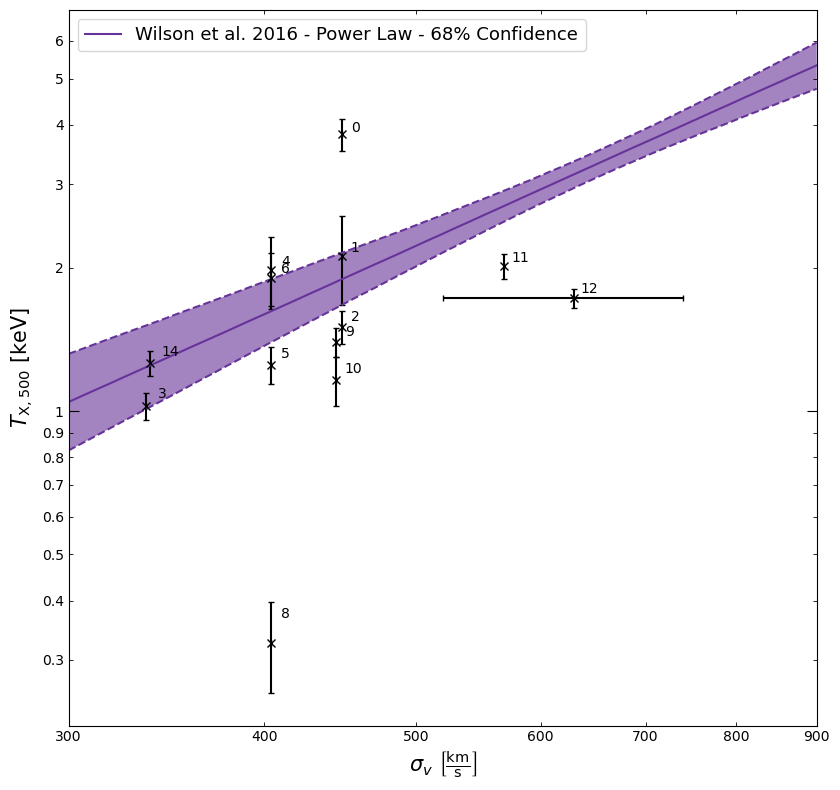

In [17]:
xcs_tx_veldisp.view(x_lims=Quantity([300, 900], 'km/s'), log_scale=True, label_points=True, 
                    conf_level=68, plot_title='', figsize=(8.5, 8), 
                    save_path="../../outputs/figures/xcs_veldisp_tx_comp_wlabels.pdf")

### Viewing without point labels

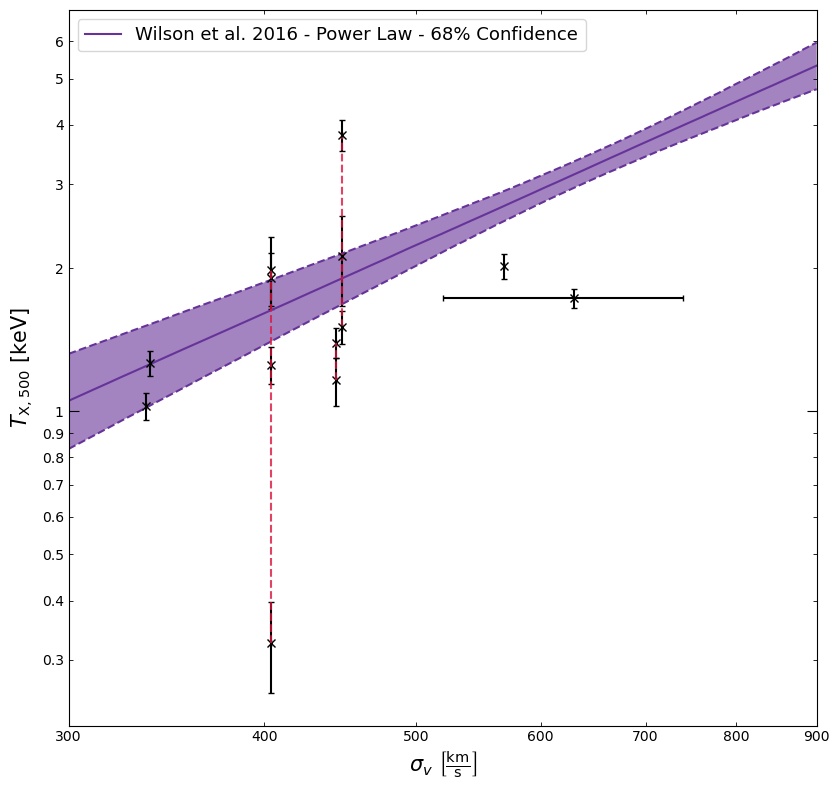

In [71]:
plt.figure(figsize=(8.5, 8))
ax = plt.gca()
ax = xcs_tx_veldisp.get_view(ax, x_lims=Quantity([300, 900], 'km/s'), log_scale=True, label_points=False, 
                             conf_level=68, plot_title='')

# This part draws lines between the data points which represent different X-ray counterparts to the same optical group, and
#  as such have had the same velocity dispersion assigned
con_samp_msk = comb['name'].str.contains('25124')
con_samp = comb[con_samp_msk]
plt.plot(con_samp['ov_obs_ad'].values[:2], [np.nanmin(tx[con_samp_msk, 0].value), np.nanmax(tx[con_samp_msk, 0].value)], 
         color='crimson', linestyle='dashed', alpha=0.8)

con_samp_msk = comb['name'].str.contains('12833')
con_samp = comb[con_samp_msk]
plt.plot(con_samp['ov_obs_ad'].values[:2], [np.nanmin(tx[con_samp_msk, 0].value), np.nanmax(tx[con_samp_msk, 0].value)], 
         color='crimson', linestyle='dashed', zorder=10, alpha=0.8)

con_samp_msk = comb['name'].str.contains('19670')
con_samp = comb[con_samp_msk]
plt.plot(con_samp['ov_obs_ad'].values[:2], [np.nanmin(tx[con_samp_msk, 0].value), np.nanmax(tx[con_samp_msk, 0].value)], 
         color='crimson', linestyle='dashed', zorder=4, alpha=0.8)

plt.legend(loc="best", fontsize=13)
plt.tight_layout()

plt.savefig("../../outputs/figures/xcs_veldisp_tx_comp.pdf")
plt.show()
plt.close('all')